In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
from sklearn import linear_model, datasets
from skimage.measure import LineModelND, ransac
import math
from __future__ import division 

import os
import glob

### For getting angle of two lines:

In [2]:
def get_angle(points1,points2):
        p1 = points1[0]
        p2 = points2[0]
        L1 = line(p1, points1[1])
        L2 = line(p2, points2[1])

        p0 = intersection(L1,L2)
        if p0 == False:
            return False,False
        v0 = np.array(p1) - np.array(p0)
        v1 = np.array(p2) - np.array(p0)

        angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
        return p0, np.degrees(angle)
              
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False


### For preprocessing on green:

In [3]:
def findgreen(image, modus = False):
    thres = 63
    if not modus:
        # find sample methods
        ys = np.random.choice(np.linspace(200,479,278),100)
        xs = np.random.choice(np.linspace(0,600,601),100)
        values = [image[int(ys[i]),int(xs[i])] for i in range(100)]
        countVal = Counter(values)
        modi = countVal.most_common(10)
        i =0
        modus = modi[0][0]
        while modus < 100 and i<9:
#             print("hi")
            i+= 1
            modus = modi[i][0]
#         print(modus,modi)        
    # optie om via arrays sneller te maken
    minmod = np.array(np.array(modus) - thres)
    maxmod = np.array(np.array(modus) + thres)
    
#     return image[image<maxmod and image>minmod]
    nimage = image[:].copy()
    
    # Via opencv
    nimage = cv2.inRange(image,minmod,maxmod)
    
    return nimage, modus

## The Field seperation function:

In [23]:
def getField2(img):
    blur =cv2.GaussianBlur(img,(71,71),10)
    hsv =  cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    greenFiltered,modus = findgreen(np.array(s))
    edge = cv2.Canny(greenFiltered, 20,40)
    ransac = linear_model.RANSACRegressor()
    y,x = np.argwhere(edge == 255)[:,0], np.argwhere(edge == 255)[:,1]
    
    #preprocess:
    bot_mask = y < 400
    xp = x[bot_mask]
    yp = y[bot_mask]
    data = np.array([xp,yp]).T
    
    # use RANSAC to find field line
    from skimage.measure import LineModelND, ransac
    model_robust, inliers_mask = ransac(data, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
    outliers_mask = inliers_mask == False
    yin = data.T[1][inliers_mask]
    xin = data.T[0][inliers_mask]
    
    # from points get line:
    Ny,Nx = np.shape(edge)
    xdiff = xin[0] - xin[-1]
    ydiff = yin[0] - yin[-1]
    if xdiff == 0 or ydiff == 0:
        # in case line is horizontal or vertical
        exit()
    a = ydiff/xdiff
    b = yin[0] - xin[0]*a
    line = a*np.arange(Nx) + b

    # Do same for second line:
    data2 = data[outliers_mask]
    model_robust, inliers_mask = ransac(data2, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
    yin = data2.T[1][inliers_mask]
    xin = data2.T[0][inliers_mask]

    # from points get line:
    Ny,Nx = np.shape(edge)
    xdiff = xin[0] - xin[-1]
    ydiff = yin[0] - yin[-1]
    if xdiff == 0 or ydiff == 0:
        # in case line is horizontal or vertical
        exit()
    a = ydiff/xdiff
    b = yin[0] - xin[0]*a
    line2 = a*np.arange(Nx) + b

    # green -> black MASK1
    hsv =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    greenMask, _ = findgreen(np.array(s), modus)
    img = cv2.bitwise_and(img,img,mask = ~greenMask)
    
    # Area enclosed by first line
    # Polygon coordinates [[top left], [top right], [bottom right], [bottom left]]
    area1 = np.array([[[0,0],[Nx,0],[Nx,line[-1]],[0, line[0]]]], dtype=np.int32)
    # ... second line
    

    # Using tilde (~) to fill in either the field or the non-field part
    original_copy = img
    cv2.fillPoly(original_copy, area1, 0)
    p0, angle = get_angle([[0,line[0]],[Nx, line[-1]]], [[0,line2[0]],[Nx, line2[-1]]] )
    if not(p0 == False or p0[0] < 0 or p0[0]> Ny or p0[1] < 0 or p0[1] > Nx or abs(angle) <1):
        # no second line
        area2 = np.array( [[[0,0],[Nx,0],[Nx,line2[-1]],[0, line2[0]]]], dtype=np.int32 )
        cv2.fillPoly(original_copy, area2, 0)
    
    grayImage = cv2.cvtColor(original_copy, cv2.COLOR_BGR2GRAY)
    (thresh, bw) = cv2.threshold(grayImage, 50, 255, cv2.THRESH_BINARY)
#     print(np.shape(bw))
#     binary,_,_ = cv2.split(bw)
    return bw


# Save all masked images, MAKE SURE YOU REALLY WANT TO RUN THIS!

In [ ]:
def save_masked(img_name):
    img = cv2.imread(img_name)
    img_name = os.path.basename(img_name)
    maskedImg = getField2(img)
    maskedImg.dtype='uint8'
    cv2.imwrite(os.path.join('bin_image3', img_name), maskedImg)
    
    # Create new directory
labeled_directory = 'bin_image3'
if not os.path.isdir('./' + labeled_directory):
    os.mkdir(labeled_directory)

    # Specify directory where all images are saved
img_dir = 'imageset_131'
img_path = os.path.join(img_dir, '*g')
files = glob.glob(img_path)

for img in files:
    save_masked(img)


(480, 640)


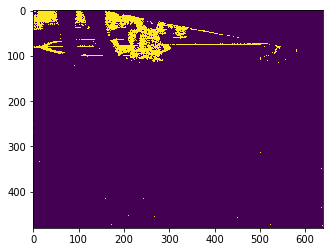

In [27]:
# img = cv2.imread("testField2.png")
img = cv2.imread("bin_image3/16_02_2018__11_18_08_0022_upper.png", 0)
# plt.imshow(img)
# plt.show()

# newim = getField2(img)
print(np.shape(img))
plt.imshow(img)
plt.show()


In [ ]:
plt.imshow(img)
plt.show()
16_02_2018__11_18_08_0005_upper.png

In [ ]:
im = cv2.imread("imageset_131/" + img_name)

In [ ]:
# def getField(img):
#     blur =cv2.GaussianBlur(img,(71,71),10)
#     hsv =  cv2.cvtColor(blur,cv2.COLOR_BGR2HSV)
#     h,s,v = cv2.split(hsv)
#     greenFiltered,modus = findgreen(np.array(s))
#     edge = cv2.Canny(greenFiltered, 20,40)
#     ransac = linear_model.RANSACRegressor()
#     y,x = np.argwhere(edge == 255)[:,0], np.argwhere(edge == 255)[:,1]

    
#     #preprocess:
#     bot_mask = y < 400
#     xp = x[bot_mask]
#     yp = y[bot_mask]
#     data = np.array([xp,yp]).T
    
#     #
#     from skimage.measure import LineModelND, ransac
#     model_robust, inliers_mask = ransac(data, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
#     outliers_mask = inliers_mask == False

#     yin = data.T[1][inliers_mask]
#     xin = data.T[0][inliers_mask]
    
#     # from points get line:
#     Ny,Nx = np.shape(edge)
#     xdiff = xin[0] - xin[-1]
#     ydiff = yin[0] - yin[-1]
#     if xdiff == 0 or ydiff == 0:
#         # in case line is horizontal or vertical
#         exit()
#     a = ydiff/xdiff
#     b = yin[0] - xin[0]*a
#     line = a*np.arange(Nx) + b
# #     plt.plot(line)

#     # Do same for second line:
#     data2 = data[outliers_mask]
#     model_robust, inliers_mask = ransac(data2, LineModelND, min_samples=2, residual_threshold=1, max_trials=300)
#     yin = data2.T[1][inliers_mask]
#     xin = data2.T[0][inliers_mask]
# #     plt.plot(xin,yin, "g.")

#     # from points get line:
#     Ny,Nx = np.shape(edge)
#     xdiff = xin[0] - xin[-1]
#     ydiff = yin[0] - yin[-1]
#     if xdiff == 0 or ydiff == 0:
#         # in case line is horizontal or vertical
#         exit()
#     a = ydiff/xdiff
#     b = yin[0] - xin[0]*a
#     line2 = a*np.arange(Nx) + b
# #     plt.plot(line2)
# #     plt.show()
#     p0, angle = get_angle([[0,line[0]],[Nx, line[-1]]], [[0,line2[0]],[Nx, line2[-1]]] )
# #     print(angle)

    
#     # Area enclosed by first line
#     # Polygon coordinates [[top left], [top right], [bottom right], [bottom left]]
#     area1 = np.array([[[0,0],[Nx,0],[Nx,line[-1]],[0, line[0]]]], dtype=np.int32)
#     # ... second line
    
#     cv2.fillPoly(edge, area1, 255)

#     # Using tilde (~) to fill in either the field or the non-field part
# #     plt.subplot(121), plt.imshow(~edge, cmap='Greys_r')

# #     plt.imshow(img)
# #     plt.figure()
#     original_copy = img
#     cv2.fillPoly(original_copy, area1, 125)
#     if not(p0 == False or p0[0] < 0 or p0[0]> Ny or p0[1] < 0 or p0[1] > Nx or abs(angle) <1):
#         # no second line
# #         print("Second line:")
#         area2 = np.array( [[[0,0],[Nx,0],[Nx,line2[-1]],[0, line2[0]]]], dtype=np.int32 )
#         cv2.fillPoly(edge, area2, 255)
#         cv2.fillPoly(original_copy, area2, 0)
# #     plt.subplot(122), plt.imshow(original_copy)
# #     img_name = "Leonstest.png"
# #     cv2.imwrite(os.path.join('masked_image', img_name), original_copy)
#     return original_copy, modus
# #     plt.show()
